# Ensemble methods
So far, we have examined individual machine learning models. What happens if we combine several models together? An _ensemble_ combines the predictions of multiple individual models to produce more accurate and robust predictions. The idea behind ensemble methods is to create a diverse set of base models that can complement each other's strengths and weaknesses, resulting in a more accurate and reliable final prediction. Ensembles are especially in situations where the individual models may be prone to overfitting or have high bias/variance.

Like we did for the decision trees in `DecisionTree.ipynb`, we will use ensemble methods to predict if a given LEGO set is of the Duplo, Bionicle, or Education theme based on the set's weight and number of pieces.

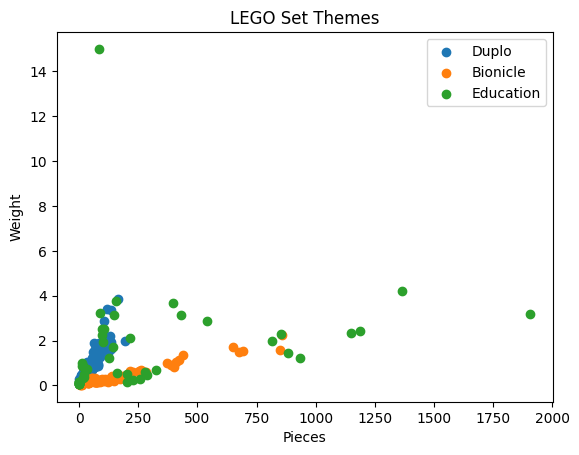

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Read in dataset and keep relevant columns/rows
df = pd.read_csv('data/Brickset-Most-Owned-Query-33-02042023.csv', index_col="Number")
df = df.filter(["Theme", "Pieces", "Weight"])
df.columns = ["Theme", "Pieces", "Weight"]
df = df[(df["Theme"] == "Duplo")
        | (df["Theme"] == "Bionicle")
        | (df["Theme"] == "Education")]
df = df.dropna()

# Write inicators
df["Indicator"] = np.where(df["Theme"] == "Duplo", 0,
                  np.where(df["Theme"] == "Bionicle", 1,
                  np.where(df["Theme"] == "Education", 2, -1)))

# Plot datapoints
themes = ["Duplo", "Bionicle", "Education"]
for theme in themes:
    bool_inds = df["Theme"] == theme
    plt.scatter(df["Pieces"][bool_inds], df["Weight"][bool_inds], label=theme)
plt.legend()
plt.title("LEGO Set Themes")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

# Train/test split of data
X_train, X_test, y_train, y_test = train_test_split(df[["Pieces", "Weight"]].to_numpy(),
                                                    df["Indicator"].to_numpy(), 
                                                    test_size=0.3, 
                                                    random_state=0)

## Bootstrap aggregating (bagging)
Bagging is an ensemble machine learning technique creates multiple base models using different subsets of the training data and then combines their predictions through majority voting. Bagging is particularly useful when the base models have high variance and are prone to overfitting, as the averaging of their predictions helps to reduce the overall variance of the model.

To create an bagging ensemble on $N$ models, we use the following bootstrapping procedure:
1. Instantiate $N$ machine learning models.
2. For each model, train the model on a random subset of the training data, with replacement.

To make a prediction with the ensemble, we use the following aggregation procedure:
1. Make a prediction using each of the $N$ models.
2. Average the predictions of the models as the single final output of the bagging ensemble.

### Bagging 1-nearest-neighbor
We will implement a bootstrap aggregation on 500 1-nearest-neighbor models using `sklearn`.

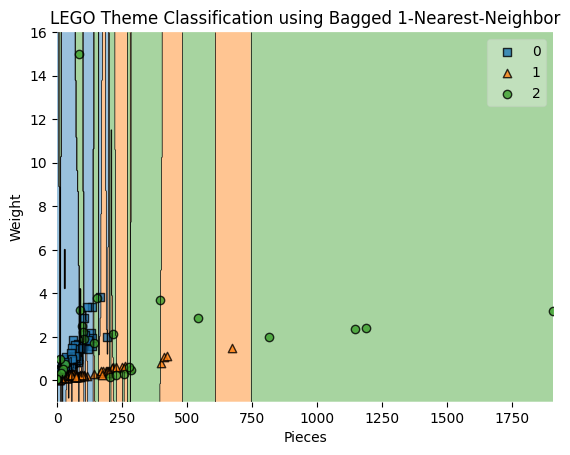

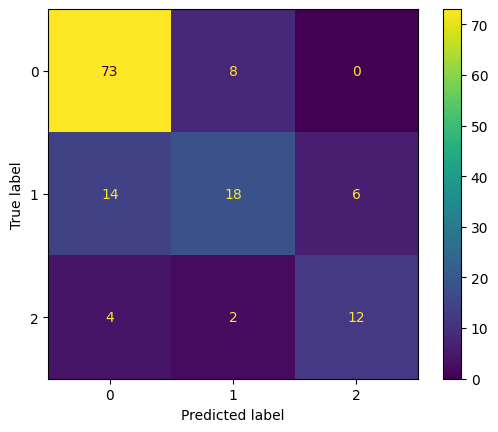

              precision    recall  f1-score   support

           0       0.80      0.90      0.85        81
           1       0.64      0.47      0.55        38
           2       0.67      0.67      0.67        18

    accuracy                           0.75       137
   macro avg       0.70      0.68      0.69       137
weighted avg       0.74      0.75      0.74       137



In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

# Build bagging ensemble on 1-nearest-neighbor classifiers
bag_1nn = BaggingClassifier(KNeighborsClassifier(n_neighbors=1),
                            n_estimators = 500,
                            bootstrap = True,
                            n_jobs = -1,
                            random_state=0)
bag_1nn.fit(X_train, y_train)

# Plot decision boundaries
plot_decision_regions(X_train, y_train, clf=bag_1nn)
plt.title("LEGO Theme Classification using Bagged 1-Nearest-Neighbor")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

# Make predictions on testing data
prediction = bag_1nn.predict(X_test)

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

# Classifier metrics
print(metrics.classification_report(y_test, prediction))

The classification is decent! Duplo LEGO sets were accurately predicted, but the Bionicles set predictions are inadequate. However, observe that the Education set predictions are very reasonable, with an f1-score of 0.67. The bagging approach shows great improvement over our previous non-ensemble attempts to classify Education sets, particularly because our dataset is highly unbalanced with very few Education observations: In `KNearestNeighbors`, a 5-nearest-neighbor model predicted Education labels with an f1-score of only 0.40.

### Bagging decision tree
We can also build a bagging ensemble on decision trees. Let's build a bagging ensemble on 500 1-depth decision trees, known as decision stumps.

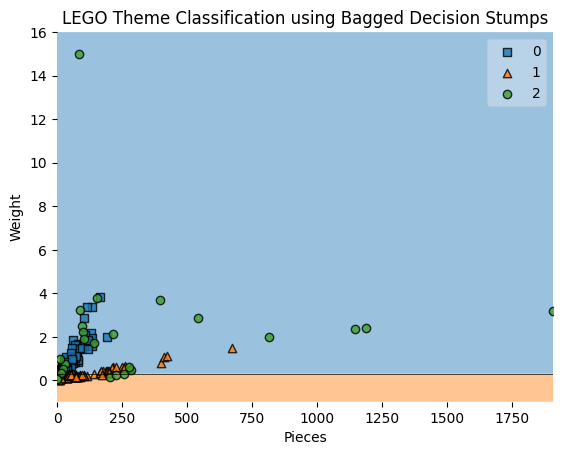

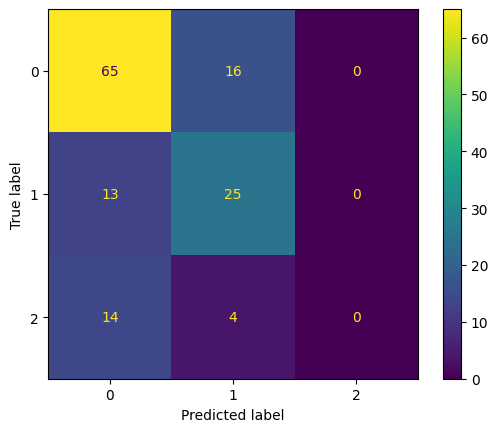

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        81
           1       0.56      0.66      0.60        38
           2       0.00      0.00      0.00        18

    accuracy                           0.66       137
   macro avg       0.42      0.49      0.45       137
weighted avg       0.57      0.66      0.61       137



C:\Users\georg\OneDrive\Documents\Rice University\Current Coursework\INDE 577\INDE_577_Data_Science_and_Machine_Learning\pip_venv_inde577\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\georg\OneDrive\Documents\Rice University\Current Coursework\INDE 577\INDE_577_Data_Science_and_Machine_Learning\pip_venv_inde577\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\georg\OneDrive\Documents\Rice University\Current Coursework\INDE 577\INDE_577_Data_Science_and_Machine_Learning\pip_venv_inde577\lib\si

In [3]:
from sklearn.tree import DecisionTreeClassifier

# Build bagging ensemble on decision tree classifiers
bag_tree = BaggingClassifier(DecisionTreeClassifier(max_depth=1),
                            n_estimators = 500,
                            bootstrap = True,
                            n_jobs = -1,
                            random_state=0)
bag_tree.fit(X_train, y_train)

# Plot decision boundaries
plot_decision_regions(X_train, y_train, clf=bag_tree)
plt.title("LEGO Theme Classification using Bagged Decision Stumps")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

# Make predictions on testing data
prediction = bag_tree.predict(X_test)

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

# Classifier metrics
print(metrics.classification_report(y_test, prediction))

This is a bad classifier, performing no better than a single, non-ensemble decision stump. Why? We suspect that the `Weight` feature is such an overwhelmingly significant predictive feature that a majority of the bagged decision stumps split along the `Weight` feature. So the outcome is that there are almost no splits along the `Pieces` feature.

## Random forest
Random forests are another way to build ensembled models. Random forests behave similarly to bootstrap-aggregated decision trees. The difference is that random forests use random feature selection: when training each decision tree, the selected features to branch upon are somewhat randomly selected, which reduces the similaritiy of each of the ensembled decision trees. This reduces the correlation between the trees' predictions, so the trees avoid making the same errors as each other, leading to better performance.

Let's build a random forest on 500 decision stumps so we can compare with the bagged decision tree approach.

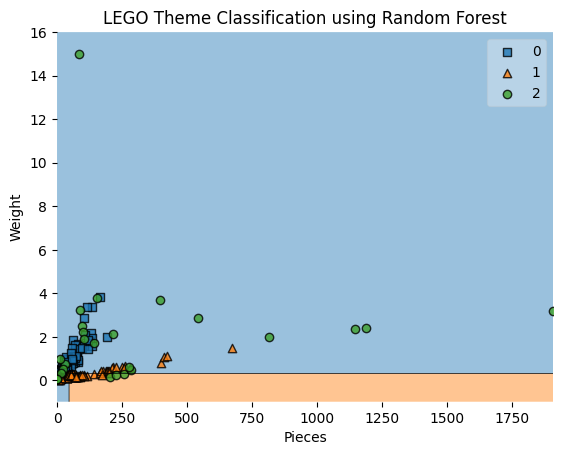

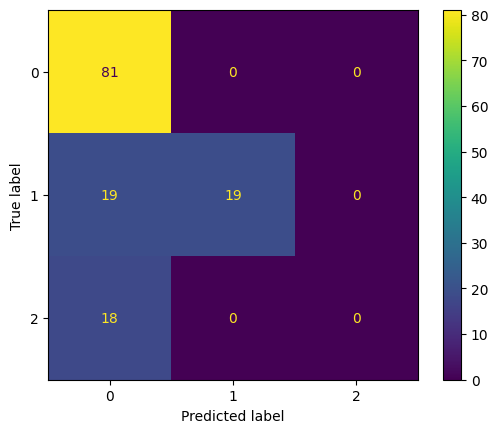

              precision    recall  f1-score   support

           0       0.69      1.00      0.81        81
           1       1.00      0.50      0.67        38
           2       0.00      0.00      0.00        18

    accuracy                           0.73       137
   macro avg       0.56      0.50      0.49       137
weighted avg       0.68      0.73      0.67       137



C:\Users\georg\OneDrive\Documents\Rice University\Current Coursework\INDE 577\INDE_577_Data_Science_and_Machine_Learning\pip_venv_inde577\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\georg\OneDrive\Documents\Rice University\Current Coursework\INDE 577\INDE_577_Data_Science_and_Machine_Learning\pip_venv_inde577\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\georg\OneDrive\Documents\Rice University\Current Coursework\INDE 577\INDE_577_Data_Science_and_Machine_Learning\pip_venv_inde577\lib\si

In [5]:
from sklearn.ensemble import RandomForestClassifier

# Build random forest
rf = RandomForestClassifier(max_depth=1,
                            n_estimators=500,
                            bootstrap = True,
                            n_jobs = -1,
                            random_state=0)
rf.fit(X_train, y_train)

# Plot decision boundaries
plot_decision_regions(X_train, y_train, clf=rf)
plt.title("LEGO Theme Classification using Random Forest")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

# Make predictions on testing data
prediction = rf.predict(X_test)

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

# Classifier metrics
print(metrics.classification_report(y_test, prediction))

Oof. The random forest is not much better than the bagged decision trees. The random forest prediction of Duplo sets is stronger than that of the bagging approach, but the Bionicle predictions are weaker. Tough luck.

However, observe that the random forest does what it is advertised to do: the random forest has additional branches `Pieces` feature that the bagged decision trees don't!

## Boosted random forests
Our final ensemble technique is boosted random forests. These are powerful upgrades to random forests, but they risk overfitting the models.

With gradient-boosted random forests, each tree is trained on the residuals of the previous trees. Each tree is intentionally trained to cancel out the errors of the previous tree. This leads to high predictive ability, but the trees can eventually begin overfitting.

Ada-boosted random forests, on the other hand, use adaptive boosting to train the decision trees in the ensemble. In this method, each tree is trained on a weighted version of the training data, with the weights adjusted based on the performance of the previous trees.

Gradient-boosted random forests are generally more accurate, while Ada-boosted random forests are easier to implement.

We will implement both using `sklearn`.

### Gradient-boosted random forest
Let's build a gradient-boosted random forest on 500 decision stumps.

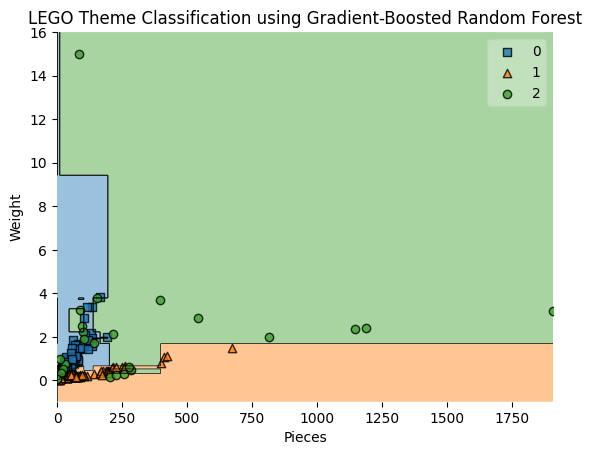

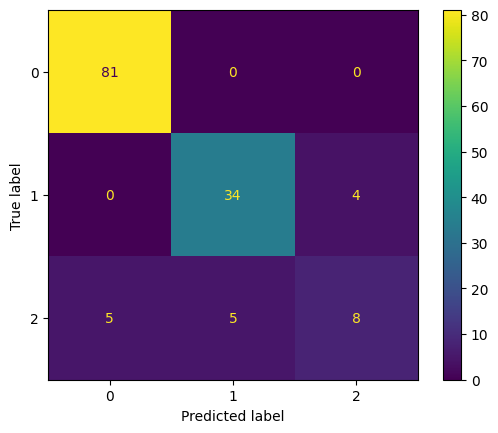

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        81
           1       0.87      0.89      0.88        38
           2       0.67      0.44      0.53        18

    accuracy                           0.90       137
   macro avg       0.83      0.78      0.80       137
weighted avg       0.89      0.90      0.89       137



In [19]:
from sklearn.ensemble import GradientBoostingClassifier

# Build gradient-boosted random forest classifier
gbrf = GradientBoostingClassifier(n_estimators=500, 
                                  learning_rate=0.1,
                                  max_depth=1, 
                                  random_state=0)
gbrf.fit(X_train, y_train)

# Plot decision boundaries
plot_decision_regions(X_train, y_train, clf=gbrf)
plt.title("LEGO Theme Classification using Gradient-Boosted Random Forest")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

# Make predictions on testing data
prediction = gbrf.predict(X_test)

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

# Classifier metrics
print(metrics.classification_report(y_test, prediction))

Wow look at that improvement! The Dulo and Bionicle predictions are excellent. Furthermore, there are successful predictions on the Education labels, with an f1-score of 0.53. This is our best ensemble classifier yet, and it vastly outperforms the bagging model and unboosted random forest.

However, we should be wary of overfitting. Some of the feature splits on the decision boundary look like they are too convoluted and may be overfit onto the training data.

### Ada-booted random forest
Let's build an ada-boosted random forest on 500 decision stumps, so we can compare with the gradient-boosted counterpart.

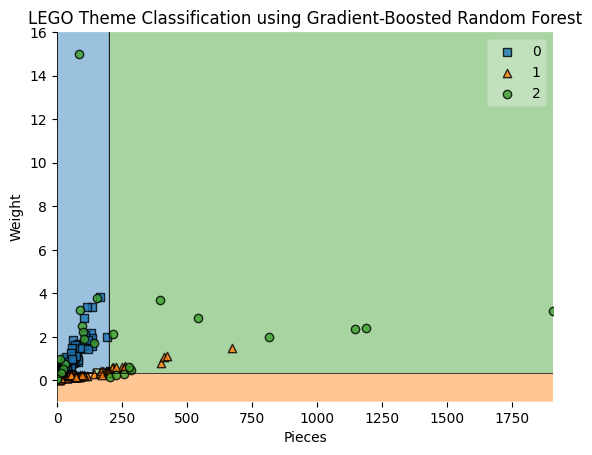

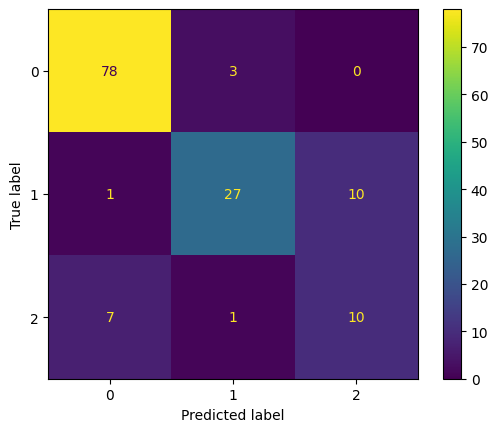

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        81
           1       0.87      0.71      0.78        38
           2       0.50      0.56      0.53        18

    accuracy                           0.84       137
   macro avg       0.76      0.74      0.75       137
weighted avg       0.84      0.84      0.84       137



In [22]:
from sklearn.ensemble import AdaBoostClassifier

# Build ada-boosted random forest classifier
abrf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                            n_estimators = 500,
                            random_state=0)
abrf.fit(X_train, y_train)

# Plot decision boundaries
plot_decision_regions(X_train, y_train, clf=abrf)
plt.title("LEGO Theme Classification using Gradient-Boosted Random Forest")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

# Make predictions on testing data
prediction = abrf.predict(X_test)

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

# Classifier metrics
print(metrics.classification_report(y_test, prediction))

The Ada-boosted random forest performs much better than the unboosted random forest. The Duplo prediction is excellent, and the Bionicle and Education predictions are decent. The Ada-boosted random forest is about as good as the gradient-boosted random forest. The gradient-boosted random forest seems to have more fine-tuned decision boundaries, but these may be the result of overfitting.

### A deeper gradient-boosted random forest
What happens if we build a gradient-boosted random forest on 3-depth trees instead of on decision stumps? We expect higher predictive ability, but we must be even more cautious of overfitting.

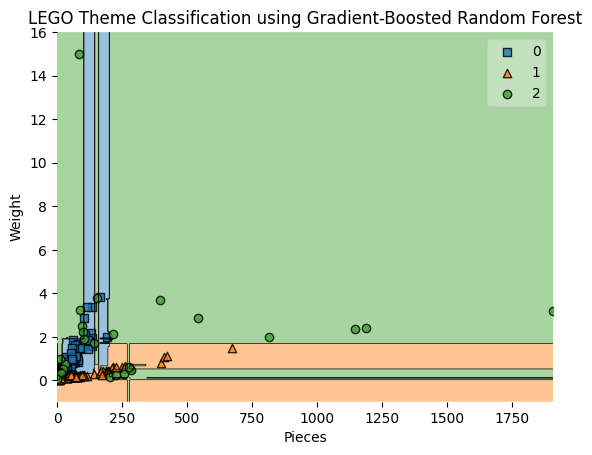

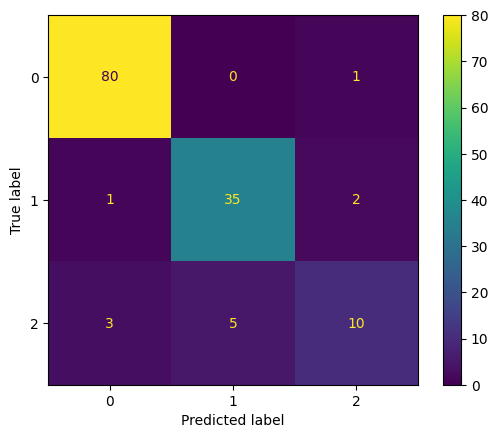

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        81
           1       0.88      0.92      0.90        38
           2       0.77      0.56      0.65        18

    accuracy                           0.91       137
   macro avg       0.87      0.82      0.84       137
weighted avg       0.91      0.91      0.91       137



In [23]:
from sklearn.ensemble import GradientBoostingClassifier

# Build gradient-boosted random forest classifier
dgbrf = GradientBoostingClassifier(n_estimators=500, 
                                  learning_rate=0.1,
                                  max_depth=3, 
                                  random_state=0)
dgbrf.fit(X_train, y_train)

# Plot decision boundaries
plot_decision_regions(X_train, y_train, clf=dgbrf)
plt.title("LEGO Theme Classification using 3-Depth Gradient-Boosted Random Forest")
plt.xlabel("Pieces")
plt.ylabel("Weight")
plt.show()

# Make predictions on testing data
prediction = dgbrf.predict(X_test)

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_display.plot()
plt.show()

# Classifier metrics
print(metrics.classification_report(y_test, prediction))

This looks like our best LEGO-set classifier yet that we've built so far, across any of our projects. The Duplo and Bionicle predictions are nearly perfect, with over 0.90 f1-score. The Education predictions are decent, with 0.65 f1-score, which is reasonable given how unbalanced the dataset.

In conclusion, we explored several ways of combining many predictive models into a single ensemble. The gradient-boosted random forest performed the best of all our approaches. We were able to make reasonable predictions on Education LEGO sets, which we were not able to do using our previous nonensemble models due to how few Education observations there are in the dataset.